---

# Clustering and Topic Modeling

The aim of this notebook is to provide analysis of tfidf, PCA decomp, clustering and topic modeling in the cleaned arXiv abstract data for papers with a subcategory in {[cs.AI](https://arxiv.org/list/cs.AI/recent), [cs.LG](https://arxiv.org/list/cs.LG/recent), [stat.ML](https://arxiv.org/list/stat.ML/recent)}.

---

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Helper Functions

In [2]:
# return a fit TfIdf model with N number of maximum features
def vectorize(text, max_features):
    vectorizer = TfidfVectorizer(max_features = max_features)
    v = vectorizer.fit_transform(text)
    return v

## <i>Load the (collected & pre-processed) data</i>

In [3]:
fname = os.path.join(os.getcwd(), 'processed_data', 'preprocessed_data.csv')
dtypes = {}
for i in ['num_authors', 'num_categories', 'title_word_count']:
    dtypes[i] = np.uint8
for i in ['abstract_sentence_count', 'abstract_word_count', 'abstract_unique_word_count']:
    dtypes[i] = np.uint16
df = pd.read_csv(fname, parse_dates = ['created'], dtype = dtypes)
print(f"Dataframe shape:{df.shape}")

Dataframe shape:(103195, 22)


In [4]:
# for our purposes here, we will exclude the 2 examples that are in French and the 3 that have no abstract text.
df = df[(df.language == 'en')]
df = df[(~df.abstract_clean.isna())]
print(f"Cleaned dataframe shape:{df.shape}.")

Cleaned dataframe shape:(103190, 22).


---

# Data Processing

- reduce to just (cs.AI, cs.LG, and stat.ML for PCA/KM/TSNE)
- Create Tf-Idf Model on $2^{12}$ (4,096) max features
- Use PCA to reduce Tf-Idf model to retain 95% components.
- Use KMeans and the [elbow method](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f) for selecting optimal K.

---


In [6]:
# reduce to just cs.AI, cs.LG, and stat.ML (~65k)
df = df[(df.primary_cat.isin(['cs.AI','cs.LG','stat.ML']))]

# product tf-idf fit model with 4,096 maximum features over cleaned abstract
clean_text = vectorize(text = df.abstract_clean.values, max_features = 2 ** 12)
print(f"tfidf array shape:{clean_text.shape}.")

# utilize PCA dimensionality reduction, retaining 95% components
pca = PCA(n_components = 0.95, random_state = 42)
reduced = pca.fit_transform(clean_text.toarray())
print(f"PCA array shape:{reduced.shape}.")

tfidf array shape:(68318, 4096).
PCA array shape:(68318, 2933).


In [6]:
# evaluate K means with 2 to 50 K to find the optimal K using the elbow method.
euclidean, km_scores, silhouette, db = [], [], [], []

for k in range(2, 60):
    km = KMeans(n_clusters = k, random_state = 42).fit(reduced)
    preds = km.predict(reduced)

    # KMeans score
    out = -km.score(reduced)
    print(f"Score for number of clusters ({k}): {out}.")
    km_scores.append(out)
    
    # euclidean distortion
    out = sum(np.min(cdist(reduced, km.cluster_centers_, 'euclidean'), axis = 1)) / reduced.shape[0]
    print(f"Euclidean distortion for clusters ({k}): {out}")
    euclidean.append(out)

    # silhouette method
    out = metrics.silhouette_score(reduced, preds)
    print(f"Silhouette score for number of clusters ({k}): {out}")
    silhouette.append(out)
    
    out = metrics.davies_bouldin_score(reduced, preds)
    print(f"Davies Bouldin score for number of clusters ({k}): {out}.")
    db.append(out)
    
    print("-"*100)


Score for number of clusters (2): 93829.67909678881.
Euclidean distortion for clusters (2): 0.9532260159552699
Davies Bouldin score for number of clusters (2): 12.963042029976416.
----------------------------------------------------------------------------------------------------
Score for number of clusters (3): 93398.67623309218.
Euclidean distortion for clusters (3): 0.9509906909054818
Davies Bouldin score for number of clusters (3): 11.070279121122178.
----------------------------------------------------------------------------------------------------
Score for number of clusters (4): 93015.18980208696.
Euclidean distortion for clusters (4): 0.9489373887514587
Davies Bouldin score for number of clusters (4): 9.537911707045575.
----------------------------------------------------------------------------------------------------
Score for number of clusters (5): 92651.21150408799.
Euclidean distortion for clusters (5): 0.947061455203881
Davies Bouldin score for number of clusters (5):

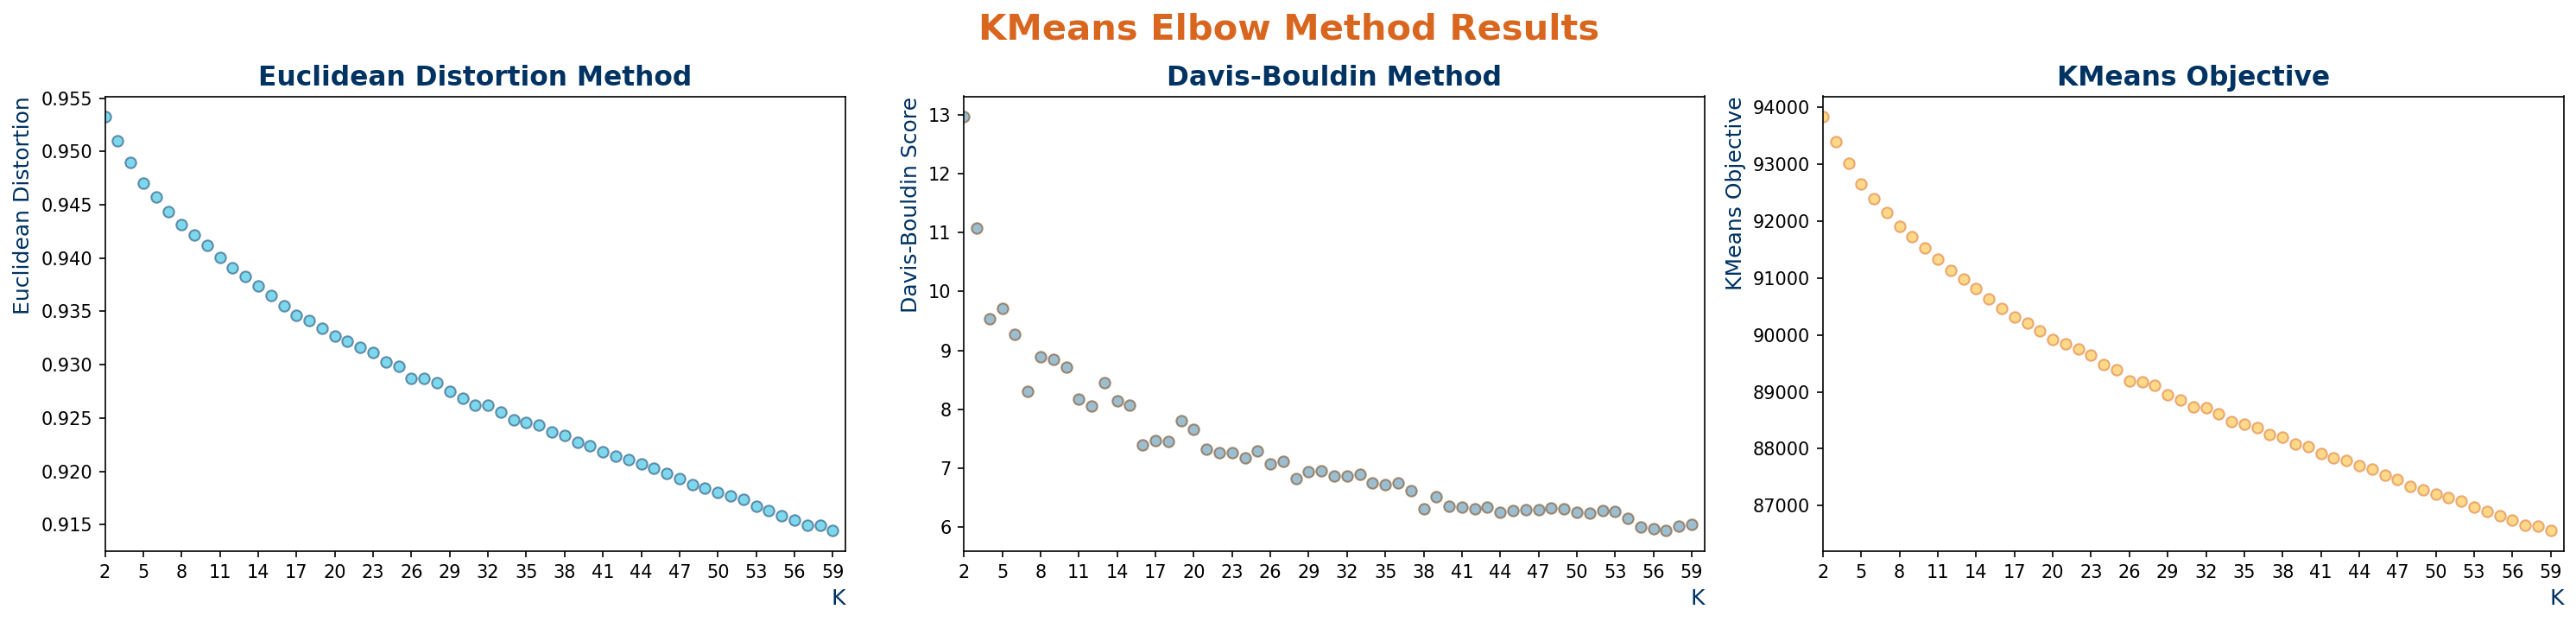

In [11]:
berkeley_palette = {'berkeley_blue'     : '#003262',
                    'california_gold'   : '#fdb515',
                    'founders_rock'     : '#3b7ea1',
                    'medalist'          : '#c4820e',
                    'bay_fog'           : '#ddd5c7',
                    'lawrence'          : '#00b0da',
                    'sather_gate'       : '#b9d3b6',
                    'pacific'           : '#46535e',
                    'soybean'           : '#859438',
                    'south_hall'        : '#6c3302',
                    'wellman_tile'      : '#D9661F',
                    'rose_garden'       : '#ee1f60',
                    'golden_gate'       : '#ed4e33',
                    'lap_lane'          : '#00a598',
                    'ion'               : '#cfdd45',
                    'stone_pine'        : '#584f29',
                    'grey'              : '#eeeeee',
                    'web_grey'          : '#888888',
                    # alum only colors
                    'metallic_gold'     : '#BC9B6A',
                    'california_purple' : '#5C3160'                   
                    }

fig = plt.figure(figsize = (20, 5), dpi = 150)
ax = fig.add_subplot(131)

xlen = len(euclidean) + 2

abs_data = pd.Series(euclidean)
ax.scatter(range(2, xlen), abs_data, color = berkeley_palette['lawrence'], alpha = 0.5, edgecolor = berkeley_palette['berkeley_blue'])
#ax.plot(range(2, xlen), abs_data, color = berkeley_palette['pacific'], linestyle = '--', alpha = 1, linewidth = 3)
ax.set_xlabel("K", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Euclidean Distortion", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xlim(2, xlen)
ax.set_xticks(range(2, xlen, 3))
plt.title("Euclidean Distortion Method", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

ax = fig.add_subplot(132)
abs_data = pd.Series(db)
ax.scatter(range(2, xlen), abs_data, color = berkeley_palette['founders_rock'], alpha = 0.5, edgecolor = berkeley_palette['south_hall'])
#ax.plot(range(2, xlen), abs_data, color = berkeley_palette['pacific'], linestyle = '--', alpha = 1, linewidth = 3)
ax.set_xlabel("K", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Davis-Bouldin Score", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xlim(2, xlen)
ax.set_xticks(range(2, xlen, 3))
plt.title("Davis-Bouldin Method", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

ax = fig.add_subplot(133)
auth_data = pd.Series(silhouette)
ax.scatter(range(2, xlen), auth_data, color = berkeley_palette['california_gold'], alpha = 0.5, edgecolor = berkeley_palette['wellman_tile'])
#ax.plot(range(2, xlen), auth_data, color = berkeley_palette['pacific'], linestyle = '--', alpha = 1, linewidth = 3)
ax.set_xlabel("K", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Silhouette Score", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xlim(2, xlen)
ax.set_xticks(range(2, xlen, 3))
plt.title("Silhouette Method", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

plt.suptitle("KMeans Elbow Method Results", fontsize = 20, fontweight = 'bold', color = berkeley_palette['wellman_tile'])
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [6]:
## We're going to go with K = 15; let's write the prediction
k = 15
km = KMeans(n_clusters = k, random_state = 42).fit(reduced)
df['cluster'] = km.predict(reduced)

In [7]:
# fit tSNE
tsne = TSNE(verbose = True, perplexity = 50, random_state = 42)
tsne_embedded = tsne.fit_transform(reduced.toarray())

[t-SNE] Computing 121 nearest neighbors...


KeyboardInterrupt: 

In [8]:
clean_text.shape

(103190, 4096)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers, vectorized_data = [], []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df = 5, max_df = 0.9, stop_words = 'english', lowercase = True, token_pattern = '[a-zA-Z\-][a-zA-Z\-]{2,}'))

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
print(len(vectorized_data))